In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# We need to join the upper directory in order to access the local modules
import datetime
import os
import pickle
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

import itertools
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

In [52]:
from pytdoa.pytdoa import nonlinoptim, linoptim, brutefoptim
from pytdoa.geodesy.geodesy import SPEED_OF_LIGHT

from util import moving_average

In [5]:
plt.rcParams["font.family"] = "Linux Libertine O"
plt.rcParams["font.size"] = 20

In [6]:
# Reading the mat files
with open("comnets_data/gnbPositions.json") as gnb_file:
    data = json.load(gnb_file)

gNBs = np.array([data["gnb0"], data["gnb1"], data["gnb2"], data["gnb3"]])

with open("comnets_data/uePositions.json") as ue_file:
    data = json.load(ue_file)

UEs = np.array(
    [data["ue0"], data["ue1"], data["ue2"], data["ue3"], data["ue4"], data["ue5"]]
)

## Playing a bit with the observed TDOA values

In [34]:
# Main params
POSITION = 4
FREQUENCY_MHZ = 100  # MHz
FREQUENCY = FREQUENCY_MHZ * 1e6
OVS = 4

# Reading and filtering
toa_measurements = pd.read_csv(
    f"comnets_data/oversampling/os{OVS}/exp{POSITION}_{FREQUENCY_MHZ}mhz.csv"
)
toa_measurements.drop(
    [
        "Unnamed: 0",
    ],
    axis=1,
    inplace=True,
)

if FREQUENCY_MHZ == 100:
    toa_filt = toa_measurements.loc[~((toa_measurements == float("-inf")).any(axis=1))]
    toa_filt.reset_index(drop=True, inplace=True)

elif FREQUENCY_MHZ == 40:
    toa_measurements = toa_measurements.drop(["gNB0", "P0"], axis=1)
    toa_filt = toa_measurements.loc[~((toa_measurements == float("-inf")).any(axis=1))]
    toa_filt.reset_index(drop=True, inplace=True)

else:
    raise RuntimeError("Not a supported frequency")
toa_filt.shape

(431, 8)

In [35]:
# Calculating the theoretical values
th_toa = np.linalg.norm(UEs[POSITION] - gNBs, axis=1)
th_tdoa = (th_toa.reshape((-1, 1)) - th_toa)[np.triu_indices(4, k=1)]
th_tdoa

array([ 0.47527784,  9.15963766,  7.43049195,  8.68435983,  6.95521411,
       -1.72914572])

In [36]:
# Moving Average parameters
ma_window = 10

# Vectorized version to obtain TDOA values
if FREQUENCY_MHZ == 100:
    toas = toa_filt[["gNB0", "gNB1", "gNB2", "gNB3"]].to_numpy()
    triu_indices = np.triu_indices(4, k=1)
else:
    toas = toa_filt[["gNB1", "gNB2", "gNB3"]].to_numpy()
    triu_indices = np.triu_indices(3, k=1)
tdoas = (
    toas.reshape((toas.shape[0], toas.shape[1], 1))
    - toas.reshape((toas.shape[0], 1, toas.shape[1]))
)[:, triu_indices[0], triu_indices[1]]

# A bit of masking to remove obvious outliers
maskl, masku = (tdoas > -20), tdoas < 20
mask = (maskl & masku).all(axis=1)
tdoas = moving_average(tdoas[mask, :], ma_window)

tdoas = tdoas / FREQUENCY / float(OVS) * SPEED_OF_LIGHT 
tdoa_mean = np.mean(tdoas, axis=0)

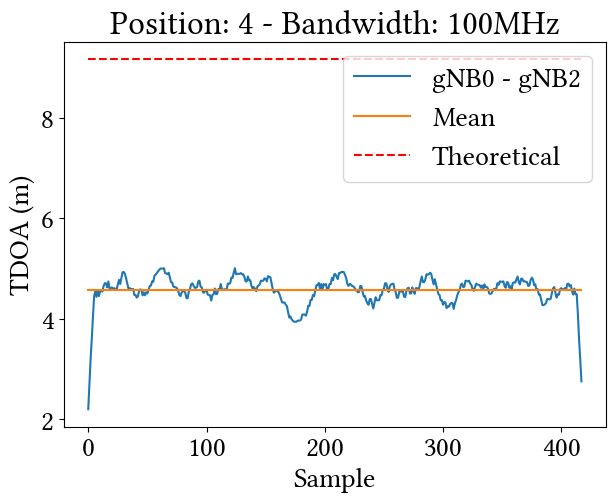

In [37]:
difference = 1
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(tdoas[:, difference])
ax.plot(tdoa_mean[difference] * np.ones(tdoas.shape[0]))
ax.plot(th_tdoa[difference] * np.ones(tdoas.shape[0]), linestyle="dashed", color="red")

ax.set_title(f"Position: {POSITION} - Bandwidth: {FREQUENCY_MHZ}MHz")
ax.set_xlabel("Sample")
ax.set_ylabel("TDOA (m)")
ax.legend(
    [
        f"gNB{triu_indices[0][difference]} - gNB{triu_indices[1][difference]}",
        "Mean",
        "Theoretical",
    ]
)

In [53]:
experiment = 1
combination_range = itertools.combinations(np.arange(len(gNBs)), 2)
combinations = np.fromiter(combination_range, dtype=np.dtype((int,2)))

linpos = linoptim(gNBs,tdoas[experiment,0:4],input_type='xyz').squeeze()
print(f"Calculated Position - x: {linpos[0]:.4f} y: {linpos[1]:.4f}")

off = False
result = nonlinoptim(gNBs, tdoas[experiment,:], combinations, num_dim=2, p0=np.array([0.0,0.0]), input_type="xyz", use_offset=off, l=.5)
print(f"Calculated Position - x: {result[0]:.4f} y: {result[1]:.4f}")

result = brutefoptim(gNBs, tdoas[experiment,:], combinations, num_dim=2, input_type="xyz")
print(f"Calculated Position - x: {result[0]:.4f} y: {result[1]:.4f}")

print(f"Real Position - x: {UEs[POSITION,0]:.4f} y: {UEs[POSITION,1]:.4f}")

Calculated Position - x: -0.7988 y: 2.5056
Calculated Position - x: 2.9750 y: 3.9427
Calculated Position - x: 2.9751 y: 3.9427


NameError: name 'POSITION' is not defined

In [39]:
# Let's do some specific processing
o = np.zeros(4)
for i in range(tdoas.shape[0]):
    result = nonlinoptim(gNBs, tdoas[experiment,:], combinations, num_dim=2, p0=linpos, input_type="xyz", use_offset=True, l=.5)
    o += result[2:]

o /= tdoas.shape[0]

In [40]:
do = (o.reshape((-1, 1)) - o.reshape(1, -1))[triu_indices[0], triu_indices[1]]
tdoas_corrected = tdoas - do
tdoas_corrected_mean = np.mean(tdoas_corrected, axis=0)

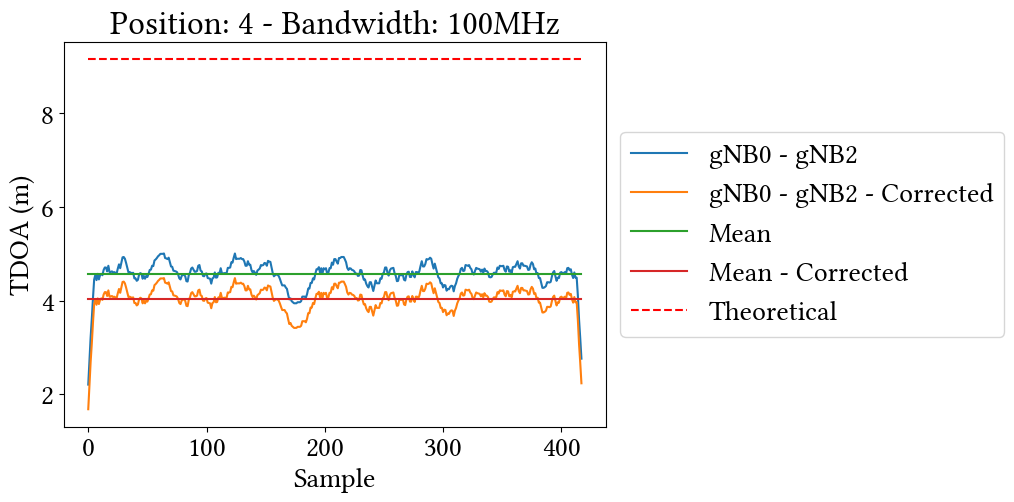

In [41]:
difference = 1
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(tdoas[:, difference])
ax.plot(tdoas_corrected[:, difference])
ax.plot(tdoa_mean[difference] * np.ones(tdoas.shape[0]))
ax.plot(tdoas_corrected_mean[difference] * np.ones(tdoas_corrected.shape[0]))
ax.plot(th_tdoa[difference] * np.ones(tdoas_corrected.shape[0]), linestyle="dashed", color="red")

ax.set_title(f"Position: {POSITION} - Bandwidth: {FREQUENCY_MHZ}MHz")
ax.set_xlabel("Sample")
ax.set_ylabel("TDOA (m)")
ax.legend(
    [
        f"gNB{triu_indices[0][difference]} - gNB{triu_indices[1][difference]}",
        f"gNB{triu_indices[0][difference]} - gNB{triu_indices[1][difference]} - Corrected",
        "Mean",
        "Mean - Corrected",
        "Theoretical",
    ],
    loc="center left", 
    bbox_to_anchor=(1, 0.5),
)

plt.show()

## Let's get this for all positions

In [7]:
# Let's analyze one frequency at a time
frequency_mhz = 100  # MHz
frequency = frequency_mhz * 1e6
ma_window = 10

result_dict = {}

result_dict["ma"] = ma_window
result_dict["frequency"] = frequency
result_dict["frequency_mhz"] = frequency_mhz
for os in [1,2,4]:
    for position in [0,4]:
        # Reading and filtering
        df = pd.read_csv(f"comnets_data/oversampling/os{os}/exp{position}_{frequency_mhz}mhz.csv")
        df.drop(
            [
                "Unnamed: 0",
            ],
            axis=1,
            inplace=True,
        )

        # Setting the stage
        n = 4  # We will use 4 gNBs except for position 4

        # This is internal knowledge
        if frequency_mhz == 100:
            df_filt = df.loc[~((df == float("-inf")).any(axis=1))]
            df_filt.reset_index(drop=True, inplace=True)

        elif frequency_mhz == 40:
            df.drop(["gNB0", "P0"], axis=1, inplace=True)

            df_filt = df.loc[~((df == float("-inf")).any(axis=1))]
            df_filt.reset_index(drop=True, inplace=True)
        
        else:
            raise RuntimeError("Unsupported frequency")

        # Calculating the theoretical values
        th_toa = np.linalg.norm(UEs[position] - gNBs, axis=1)
        th_tdoa = (th_toa.reshape((-1, 1)) - th_toa)[np.triu_indices(n, k=1)]
        result_dict[f"P{position}", "th_tdoa"] = th_tdoa

        triu_indices = np.triu_indices(n, k=1)
        tdoas = (
            toas.reshape((toas.shape[0], toas.shape[1], 1))
            - toas.reshape((toas.shape[0], 1, toas.shape[1]))
        )[:, triu_indices[0], triu_indices[1]]

        # A bit of masking to remove obvious outliers
        maskl, masku = (tdoas > -30), tdoas < 30
        mask = (maskl & masku).all(axis=1)
        tdoas = moving_average(tdoas[mask, :], ma_window)

        tdoas = tdoas / frequency * SPEED_OF_LIGHT / float(os)
        tdoas_mean = np.mean(tdoas, axis=0)

        # Let's store our precious data
        result_dict[f"os{os}",f"P{position}", "tdoas"] = tdoas
        result_dict[f"os{os}",f"P{position}", "tdoas_mean"] = tdoas_mean

NameError: name 'toas' is not defined

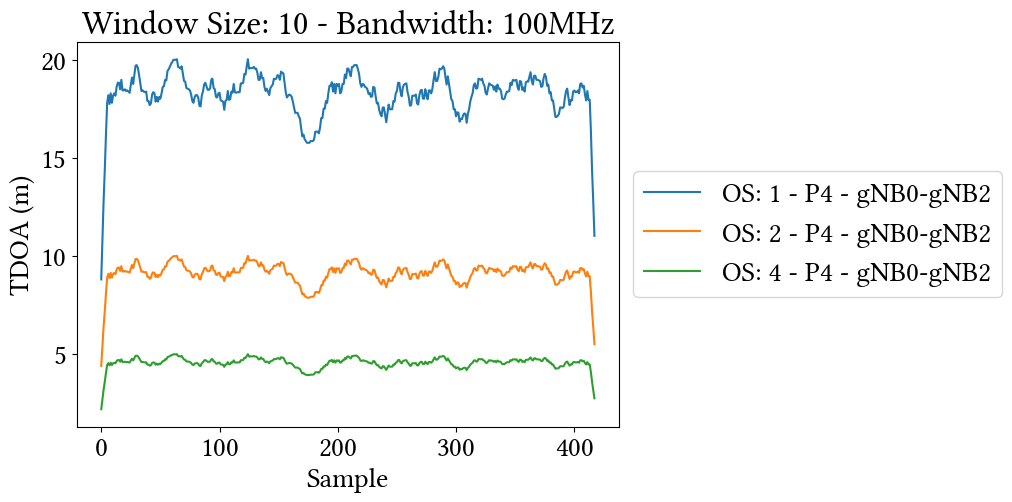

In [58]:
difference = 1

fig, ax = plt.subplots(figsize=(7, 5))

p = 4
for i in [1,2,4]:
    if i == 4 and difference > 2:
        continue
    td = result_dict[f"os{i}",f"P{p}", "tdoas"]
    ax.plot(
        td[:, difference],
        label=f"OS: {i} - P{p} - gNB{triu_indices[0][difference]}-gNB{triu_indices[1][difference]}",
    )

ax.set_title(f'Window Size: {result_dict["ma"]} - Bandwidth: {frequency_mhz}MHz')
ax.set_xlabel("Sample")
ax.set_ylabel("TDOA (m)")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.show()

## Positioning results for all positions

In [57]:
# Let's analyze one frequency at a time
frequency_mhz = 100  # MHz
frequency = frequency_mhz * 1e6
ma_window = 50
offset = False
lr = 0.1
ngnb = 4

result_dict = {}

result_dict["ma"] = ma_window
result_dict["frequency"] = frequency
result_dict["frequency_mhz"] = frequency_mhz
result_dict["offset"] = offset
result_dict["lr"] = lr
n = 4  # We will use 4 gNBs except for position 4 & 40 MHz examples
for os in [1,2,4]:
    for position in [0,4]:
        # Reading and filtering
        df = pd.read_csv(f"comnets_data/oversampling/os{os}/exp{position}_{frequency_mhz}mhz.csv")
        df.drop(
            [
                "Unnamed: 0",
            ],
            axis=1,
            inplace=True,
        )

        # This is internal knowledge
        if frequency_mhz == 100:
            df_filt = df.loc[~((df == float("-inf")).any(axis=1))]
            df_filt.reset_index(drop=True, inplace=True)
            gnbs = gNBs

        elif frequency_mhz == 40:
            n = 3
            df.drop(["gNB0", "P0"], axis=1, inplace=True)
            gnbs = gNBs[1:, :]

            df_filt = df.loc[~((df == float("-inf")).any(axis=1))]
            df_filt.reset_index(drop=True, inplace=True)

        else:
            raise RuntimeError("Unsupported frequency")

        # Calculating the theoretical values
        th_toa = np.linalg.norm(UEs[position] - gnbs, axis=1)
        th_tdoa = (th_toa.reshape((-1, 1)) - th_toa)[np.triu_indices(n, k=1)]
        result_dict[f"P{position}", "th_tdoa"] = th_tdoa

        # Vectorized version to obtain TDOA values
        if frequency_mhz == 100:
            toas = df_filt[["gNB0", "gNB1", "gNB2", "gNB3"]].to_numpy()
        elif frequency_mhz == 40:
            toas = df_filt[["gNB1", "gNB2", "gNB3"]].to_numpy()
        else:
            raise RuntimeError("Unsupported frequency")

        triu_indices = np.triu_indices(n, k=1)
        tdoas = (
            toas.reshape((toas.shape[0], toas.shape[1], 1))
            - toas.reshape((toas.shape[0], 1, toas.shape[1]))
        )[:, triu_indices[0], triu_indices[1]]

        # A bit of masking to remove obvious outliers
        maskl, masku = (tdoas > -7), tdoas < 7
        mask = (maskl & masku).all(axis=1)
        tdoas = moving_average(tdoas[mask, :], ma_window)

        tdoas = tdoas / frequency * SPEED_OF_LIGHT
        tdoas_mean = np.mean(tdoas, axis=0)

        # Let's start the positioning routines
        combination_range = itertools.combinations(np.arange(len(gnbs)), 2)
        combinations = np.fromiter(combination_range, dtype=np.dtype((int, 2)))

        linear = []
        nonlin = []
        brute = []
        for experiment in range(len(tdoas)):
            linpos = linoptim(gNBs, tdoas[experiment, 0:n], input_type="xyz").squeeze()
            result = nonlinoptim(
                gNBs,
                tdoas[experiment, :],
                combinations,
                num_dim=2,
                p0=linpos,
                input_type="xyz",
                use_offset=offset,
                l=lr,
            )

            rbrute = brutefoptim(gNBs, tdoas[experiment,:], combinations, num_dim=2, input_type="xyz")

            linear.append(linpos)
            nonlin.append(result)
            brute.append(rbrute)
        
        result_dict[f'os{os}',f'P{position}','linear'] = np.array(linear)
        result_dict[f'os{os}',f'P{position}','nonlin'] = np.array(nonlin)
        result_dict[f'os{os}',f'P{position}','brute'] = np.array(brute)

        print(f"Finished P{position} - Processed {len(tdoas)} points.")

now = round(datetime.datetime.now().timestamp())
with open(f'comnets_data/results/oversampling/{n}_{frequency_mhz}mhz_window_{ma_window}_offset_{offset}_lr_{round(lr*100)}.pickle', 'wb') as handle:
    pickle.dump(result_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

Finished P0 - Processed 295 points.
Finished P4 - Processed 1192 points.
Finished P0 - Processed 360 points.
Finished P4 - Processed 1387 points.
Finished P0 - Processed 108 points.
Finished P4 - Processed 417 points.


## Processing the results

In [58]:
import pickle
frequency_mhz = 100

In [59]:
with open(f'comnets_data/results/oversampling/4_{frequency_mhz}mhz_window_50_offset_False_lr_10.pickle', 'rb') as p:
    data_no_offset = pickle.load(p)


In [63]:
eelin_d = {}
eenli_d = {}
eebrt_d = {}
for os in [1,2,4]:
    eelin = np.array([])
    eenli = np.array([])
    eebrt = np.array([])        
    for i in [0,4]:
        ue = UEs[i]
        lin = data_no_offset[f'os{os}',f'P{i}','linear']
        nli = data_no_offset[f'os{os}',f'P{i}','nonlin']
        brt = data_no_offset[f'os{os}',f'P{i}','brute']


        elin = np.linalg.norm(ue-lin,axis=1)
        enli = np.linalg.norm(ue-nli,axis=1)
        ebrt = np.linalg.norm(ue-brt,axis=1)

        eelin = np.append(eelin, elin)
        eenli = np.append(eenli, enli)
        eebrt = np.append(eebrt, ebrt)


    
    eelin = eelin[eenli < 1000]
    print(f'Before filter: {eenli.shape[0]}')
    eenli = eenli[eenli < 1000]
    print(f'After filter: {eenli.shape[0]}')
    print(f'Before filter: {eebrt.shape[0]}')
    eebrt = eebrt[eebrt < 1000]
    print(f'After filter: {eebrt.shape[0]}')
    eelin_d[os] = eelin
    eenli_d[os] = eenli
    eebrt_d[os] = eebrt


Before filter: 1487
After filter: 648
Before filter: 1487
After filter: 1487
Before filter: 1747
After filter: 391
Before filter: 1747
After filter: 1747
Before filter: 525
After filter: 137
Before filter: 525
After filter: 525


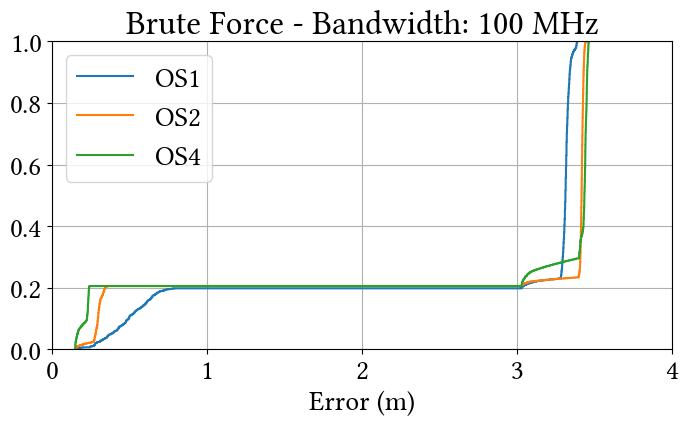

In [64]:
f, ax = plt.subplots(figsize=(8, 4))

ax.ecdf(eebrt_d[1])
ax.ecdf(eebrt_d[2])
ax.ecdf(eebrt_d[4])

ax.set_xlim([0,4])
ax.grid()

ax.set_title(f'Brute Force - Bandwidth: {frequency_mhz} MHz')
ax.set_xlabel('Error (m)')
ax.legend(['OS1', 'OS2', 'OS4'])